In [51]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from datetime import timedelta
import imageio as io
import glob 
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
from scipy import stats 
import os 

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [197]:
def get_data(date_start, date_end):

    # make a frame with station names as column and time as row
    # first, make an empty frame with desired time as column

    days = pd.date_range(datetime.datetime(2022, 1, 15, 0, 0, 0), datetime.datetime(2022, 1, 25, 0, 0, 0), freq='1min') # MUST have same granularity as txt data!

    df_empty = pd.DataFrame({'time': days})

    df_empty.head()

    # second, insert pressure data into frame!

    all_files = glob.glob('data/raw_data/*.txt')
    all_files.sort()

    for i in range(len(all_files)):

        df_tmp = pd.read_csv(all_files[i], header=0, skiprows=0, usecols=(0,4,5), index_col=1) # station, pressure
        # df_tmp.columns = ['station', 'pressure']
        if df_tmp.shape[0] > 0: # non empty data
            df_tmp.index = pd.DatetimeIndex(df_tmp.index)
            df_tmp = df_tmp.reindex(days, fill_value=np.nan)

            pressure_tmp = df_tmp['pres1']
            station_tmp = df_tmp['station'][0]

            df_empty[station_tmp] = pressure_tmp.values

    df_empty = df_empty.loc[(pd.to_datetime(df_empty['time']) > date_start) & (df_empty['time'] < date_end)]

    stations_non_empty = df_empty.columns[1:].tolist()
    
    # get location of all stations and transform to geopandas frame
    df_stations = pd.read_csv('data/stations_US.csv', index_col=0)

    df_stations = gpd.GeoDataFrame(
        df_stations, geometry=gpd.points_from_xy(df_stations['lon'], df_stations['lat']))
    # print('total number of stations: ' + str(len(df_stations)))

    all_stations = list(df_stations['station'])

    # get world map
    df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # clean nulls
    df_series = df_empty.copy()
    df_series = df_series[df_series.columns[df_series.isnull().mean() < 0.9]]
    df_series.head()

    stations = df_series.columns[1:]

    # delete stations with no data
    for s in df_stations['station']:
        if s not in stations:
            df_stations.drop(df_stations[df_stations['station']==s].index, inplace=True)
        
    print(df_series.shape)
    # print(df_stations.shape)

    return df_series, df_stations, df_world

In [198]:
def calculate(df_series, df_stations):
    # calculate percent change and find time of shock wave arriving

    t_shock = []
    dt_shock = []
    amplitude = []
    for s in df_stations['station']:

        scaled = -1 + df_series[s]/df_series[s].iloc[0]
        grad = np.gradient(scaled, 3)
        grad[np.isnan(grad)] = 0

        t_min = df_series['time'].loc[grad == np.min(grad)] # TimeStamp corresponding to most negative change

        amplitude.append(np.abs(np.min(grad)))
        t_shock.append(pd.Timestamp(t_min.values[0]))
        dt_shock.append((pd.Timestamp(t_min.values[0]) - datetime.datetime(2022, 1, 15, 0, 0, 0)).total_seconds())

    # create shock wave time columns
    df_stations['t_shock'] = t_shock
    df_stations['dt_shock'] = dt_shock
    df_stations['shock_amplitude'] = amplitude

    return df_stations

In [230]:
def plot_distributions(df_stations, left, right, shock_n):
    # distribution of shock wave time?

    plt.figure(figsize=(7,5))
    plt.hist(df_stations['dt_shock'],bins=100, histtype='step')
    plt.axvline(left, linestyle='--', color='m')
    plt.axvline(right, linestyle='--', color='m', label='Peak window')
    plt.xlabel('Time in sec from 12 AM, Jan 15 (UTC)')
    plt.legend()
    plt.title(f'{shock_n} shockwave')
    plt.show()

    plt.figure(figsize=(7,5))
    plt.hist(df_stations['shock_amplitude'],bins=50, histtype='step', log=True)
    plt.xlabel('Relative amplitude of shockwave')
    plt.title(f'{shock_n} shockwave')
    plt.show()


    plt.figure(figsize=(5,4))

    df_visualize = df_stations[(df_stations['dt_shock'] > left) & (df_stations['dt_shock'] < right)]
    r,p= stats.spearmanr(df_visualize['dt_shock'], df_visualize['shock_amplitude'])

    # plt.plot(df_stations['dt_shock'], df_stations['shock_amplitude'], '.', alpha=0, color='black',label=f'r={np.round(r,2)}, p={np.round(p,2)}')
    sns.regplot(x="dt_shock", y="shock_amplitude", data=df_visualize, color='steelblue')

    # plt.xlim(left*0.9,right*1.1)
    # plt.ylim(0,0.025)
    # plt.legend()

    plt.xlabel('Time of shock from Jan.15, 12 AM (sec)')
    plt.ylabel('Relative amplitude of gradient')
    plt.title(f'{shock_n} shockwave')
    plt.legend(labels=[f"Spearman r:{np.round(r,2)}, p={np.round(p)}"], title = None)
    plt.show()

    # save shock wave as png frames!
    t = int(1/2*(right + left))

    fig, ax = plt.subplots(figsize=(7,5))
    cm = matplotlib.cm.get_cmap('coolwarm')
    df_world.plot(ax=ax, color='whitesmoke', edgecolor='black', alpha=0.5)

    cval_raw = (1 - np.abs(df_stations['dt_shock'] - t)/50000).values
    cval_raw = (cval_raw - np.min(cval_raw)) / (np.max(cval_raw) - np.min(cval_raw))
    cval = cval_raw ** 20
    # cval = cval_raw * 1 / (1 + np.exp(-(cval_raw - 0.5)))
    color = np.array([cm(i) for i in cval])
    ax.scatter(df_stations['lon'],df_stations['lat'], marker='s', color=color, s=30*cval, alpha=1)
        
    ax.plot(-175.385,-20.55, '*', color='m', markersize=10, label='Tonga volcano')
    ax.plot()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(-180, -50)
    ax.set_ylim(-30,80)
    ax.set_title(f'{shock_n} shockwavewave; '+str(datetime.datetime(2022, 1, 15, 0, 0, 0) + datetime.timedelta(seconds=int(t))) + ' (UTC)')
    # plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.legend(prop={'size':15})
    plt.show()

# forward waves

In [214]:
df_series_1, df_stations_1, df_world = get_data(datetime.datetime(2022, 1, 15, 6, 0, 0), datetime.datetime(2022, 1, 15, 20, 0, 0))
df_stations_1 = calculate(df_series_1, df_stations_1)

(839, 832)


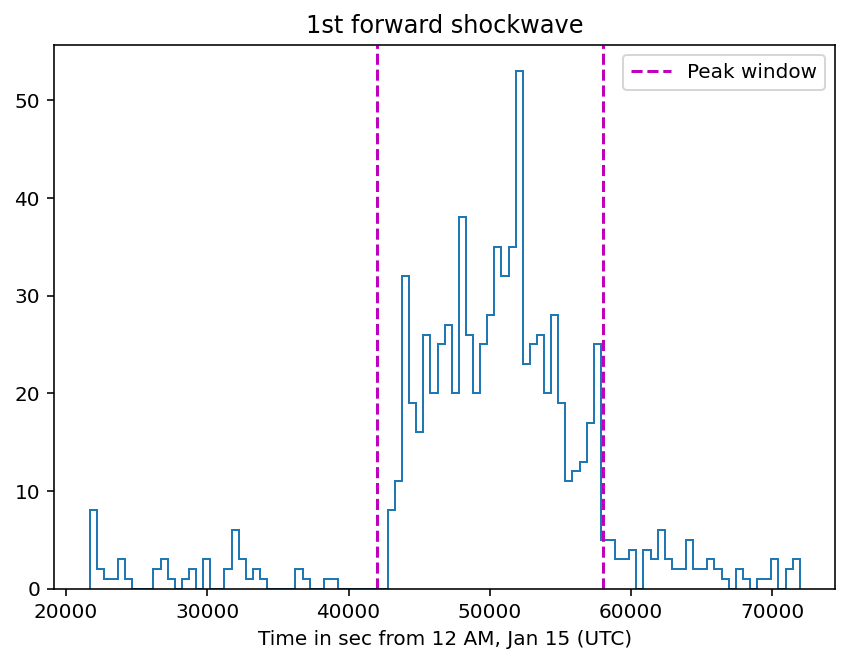

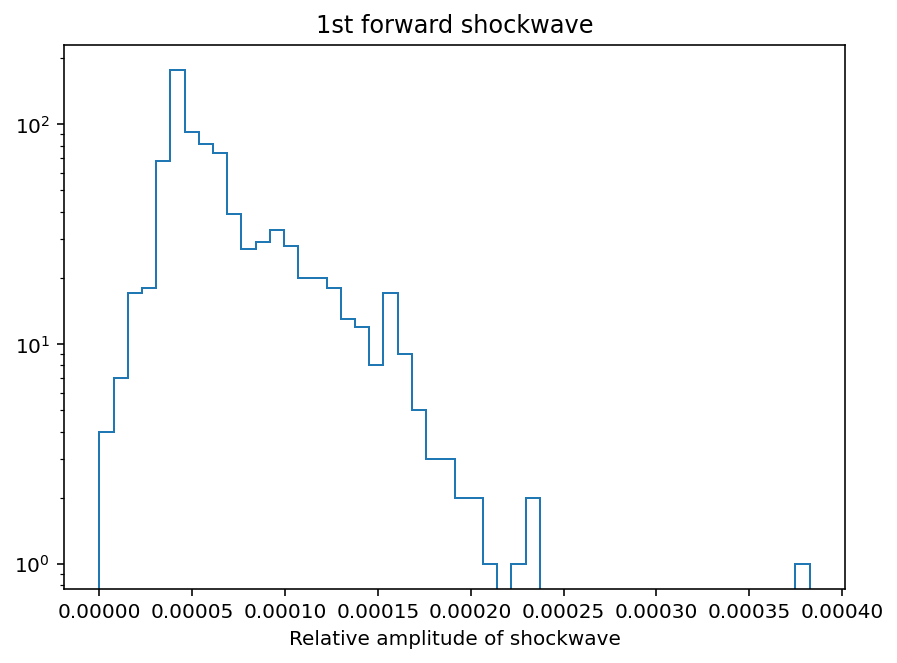

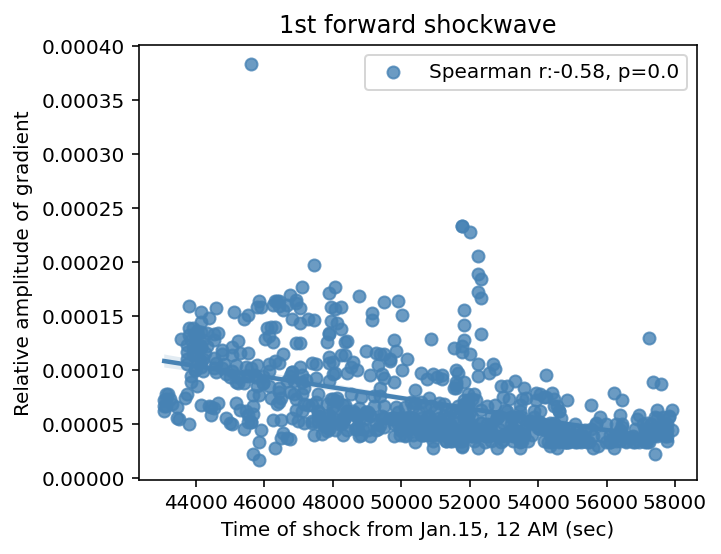

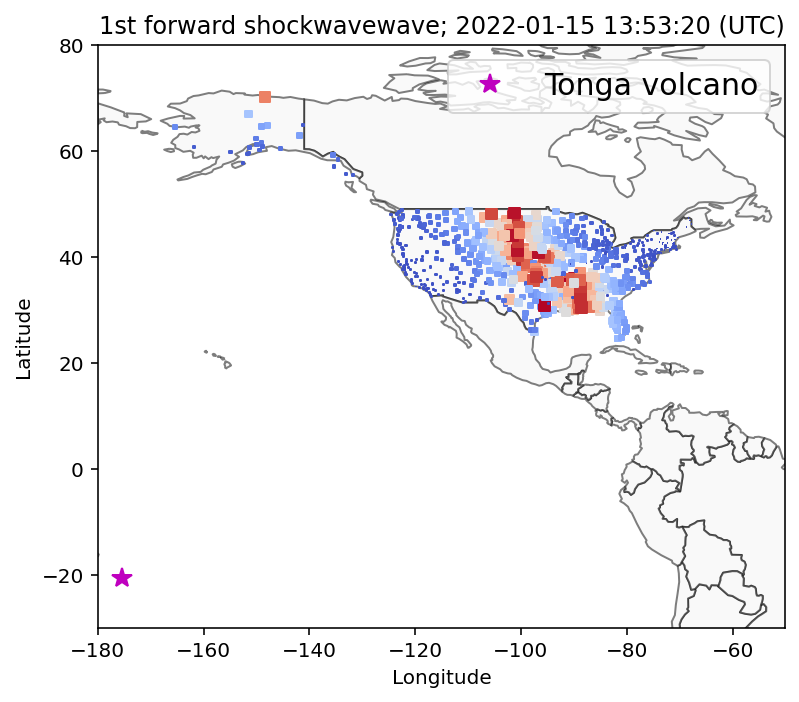

In [231]:
left_1, right_1 = 42000, 58000
plot_distributions(df_stations_1, left_1, right_1, '1st forward')

In [137]:
df_series_2, df_stations_2, df_world = get_data(datetime.datetime(2022, 1, 16, 20, 0, 0), datetime.datetime(2022, 1, 17, 4, 0, 0))
df_stations_2 = calculate(df_series_2, df_stations_2)

(479, 819)


-0.0013333333333331865
[-0.00133333]


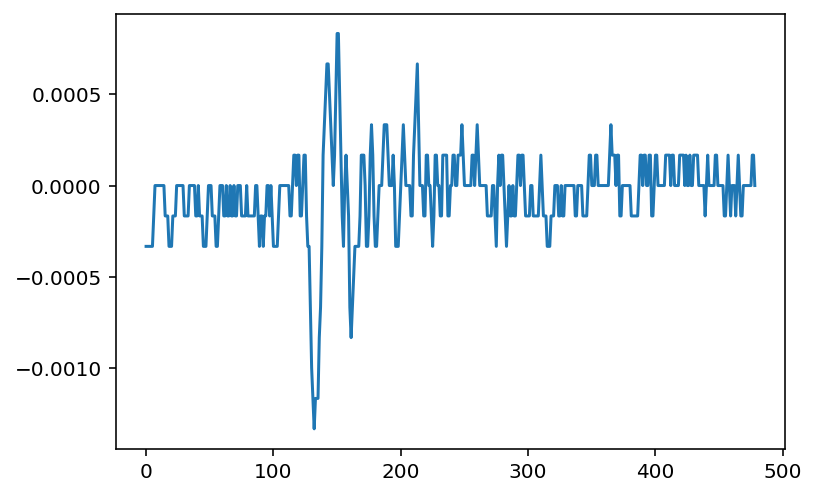

In [166]:
# plt.plot(df_series_2['OAK'])
g = np.gradient(df_series_2['SFO'], 3)
g[np.isnan(g)] = 0
plt.plot(g)
print(np.min(g))
print(g[g==np.min(g)])

In [153]:
df_stations_2

,station,lon,lat,geometry,t_shock,dt_shock,shock_amplitude
6,PANC,-150.0261,61.1697,POINT (-150.02610 61.16970),2022-01-17 00:09:00,173340.0,0.000833
16,PABE,-161.8264,60.7858,POINT (-161.82640 60.78580),2022-01-16 23:31:00,171060.0,0.000833
34,PACV,-145.4511,60.4889,POINT (-145.45110 60.48890),2022-01-17 00:14:00,173640.0,0.000833
35,PASC,-148.4652,70.1948,POINT (-148.46520 70.19480),2022-01-17 00:52:00,175920.0,0.000833
39,PAEG,-141.1496,64.7781,POINT (-141.14960 64.77810),2022-01-17 02:06:00,180360.0,0.000167
...,...,...,...,...,...,...,...
2776,RKS,-109.0652,41.5942,POINT (-109.06520 41.59420),2022-01-16 23:38:00,171480.0,0.000667
2779,SHR,-106.9700,44.7700,POINT (-106.97000 44.77000),2022-01-16 23:30:00,171000.0,0.000667
2786,TOR,-104.1528,42.0647,POINT (-104.15280 42.06470),2022-01-16 23:33:00,171180.0,0.000500
2790,WRL,-107.9508,43.9657,POINT (-107.95080 43.96570),2022-01-16 23:21:00,170460.0,0.000833


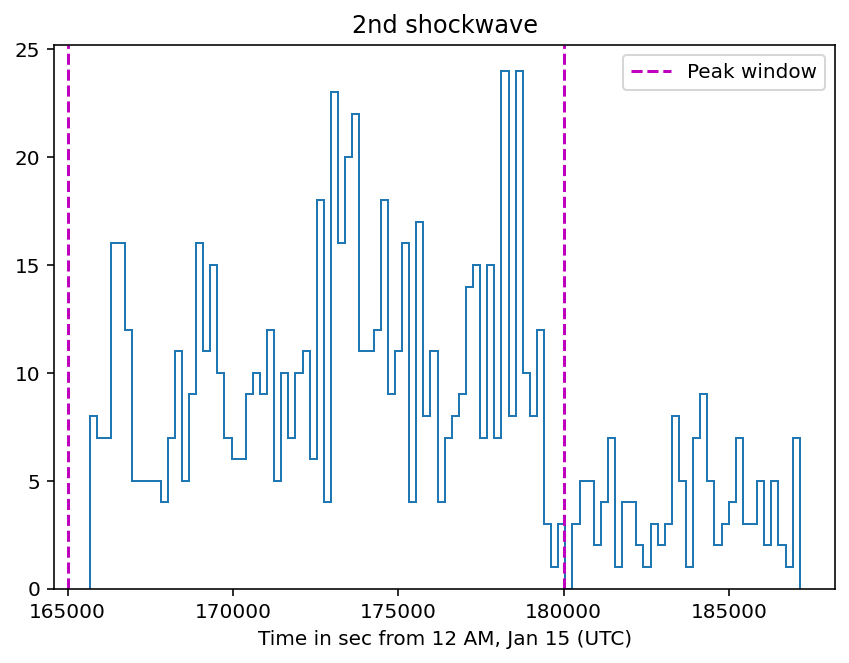

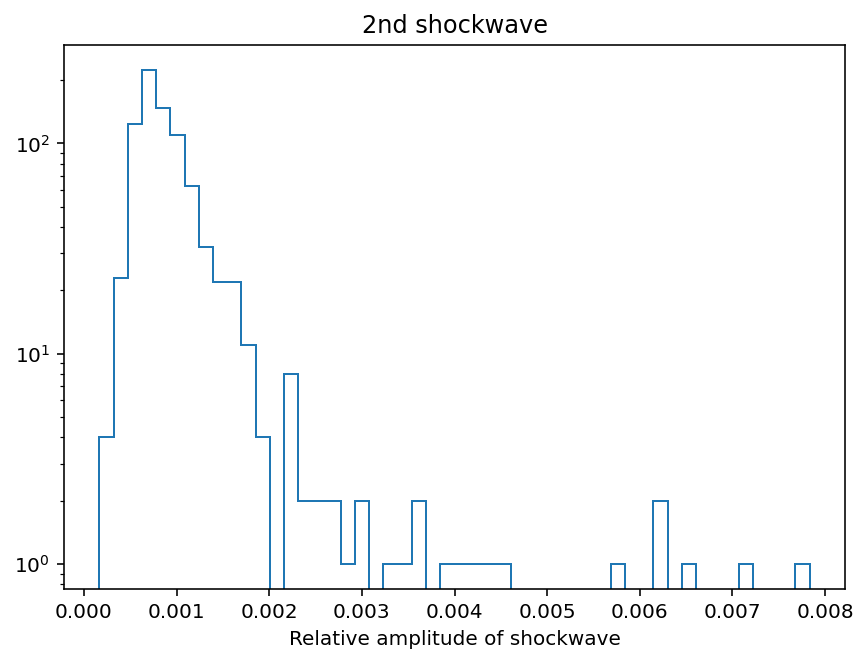

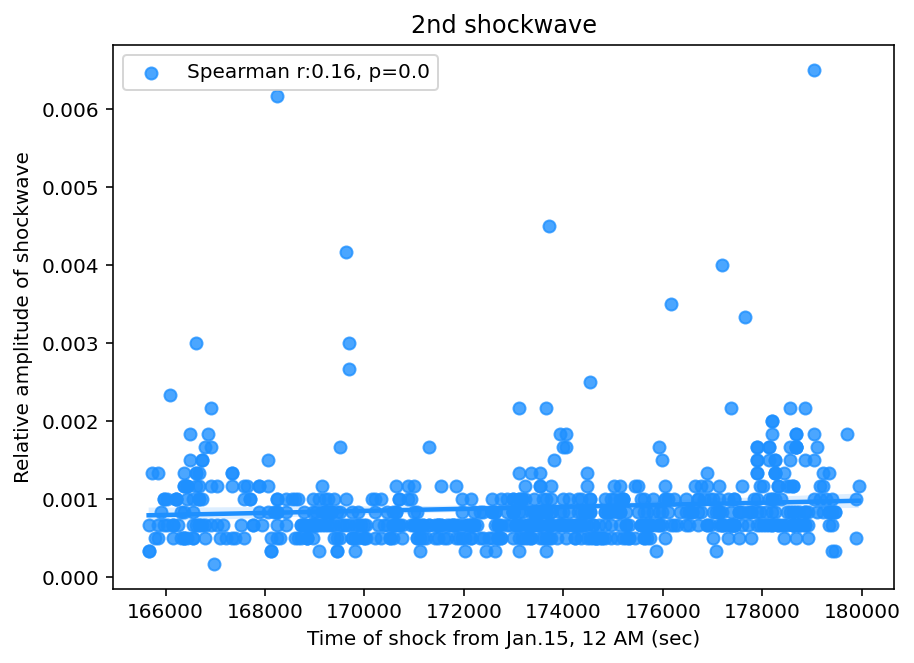

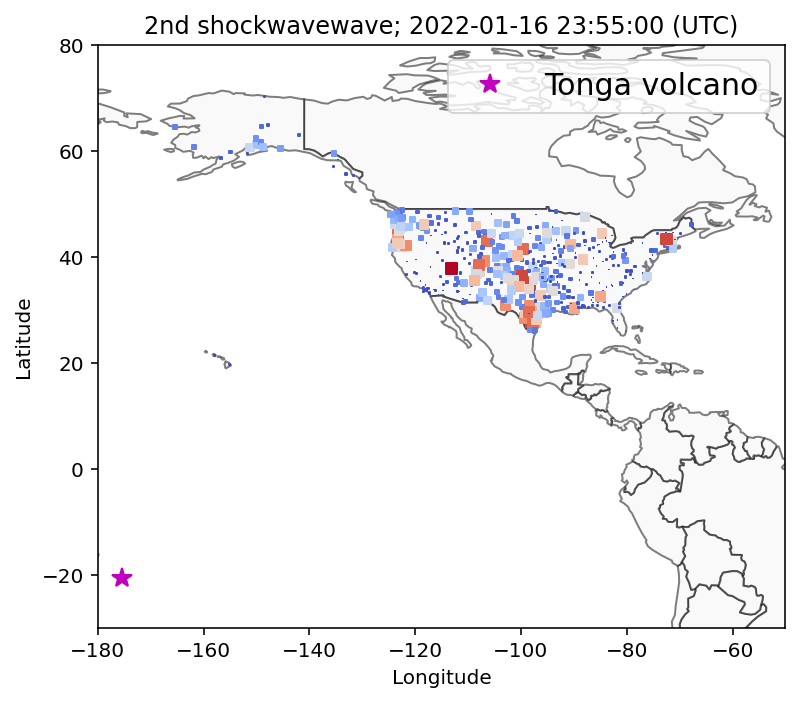

In [124]:
left_2, right_2 = 165000, 180000
plot_distributions(df_stations_2, left_2, right_2, '2nd forward')

In [173]:
df_series_3, df_stations_3, df_world = get_data(datetime.datetime(2022, 1, 18, 8, 0, 0), datetime.datetime(2022, 1, 18, 16, 0, 0))
df_stations_3 = calculate(df_series_3, df_stations_3)

(479, 818)


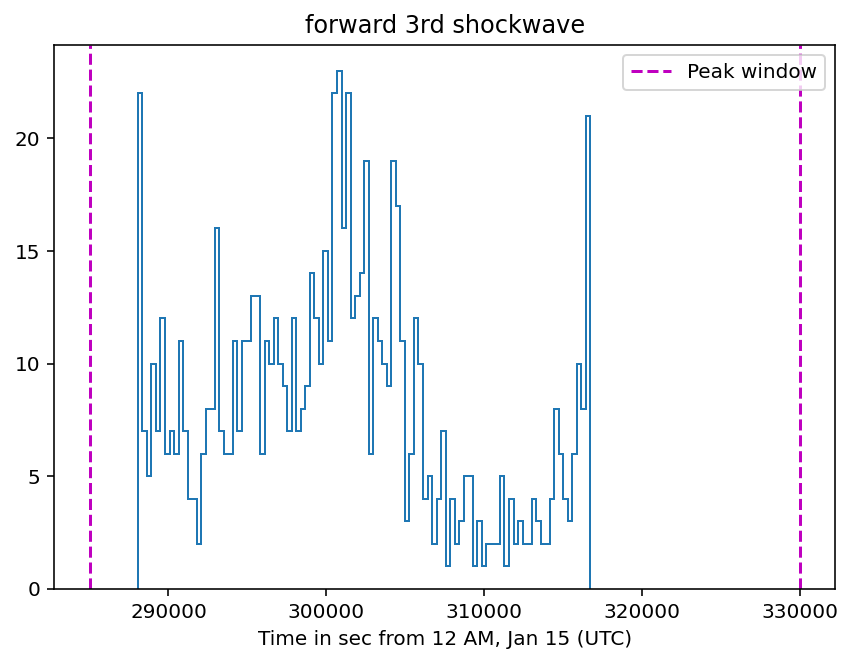

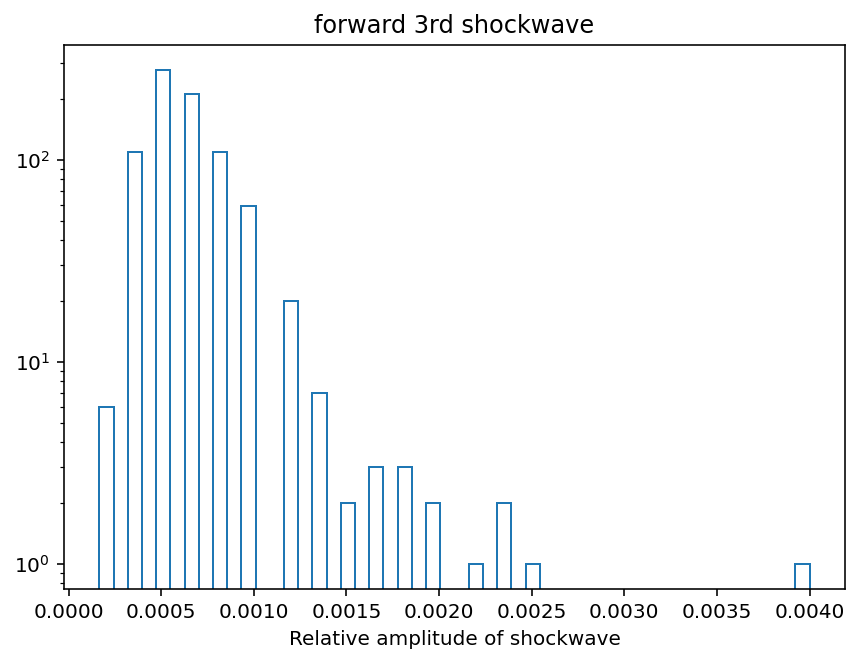

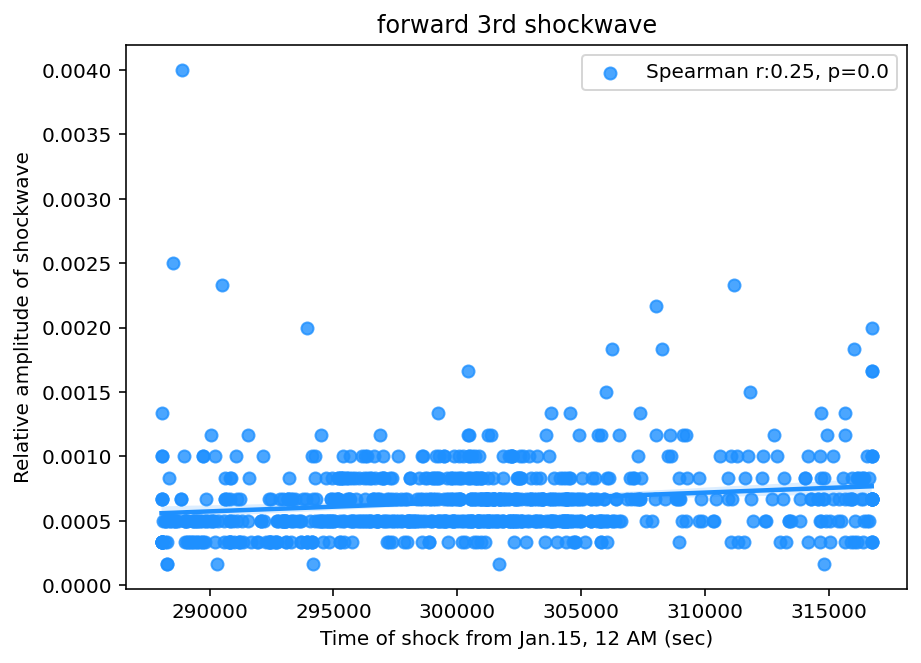

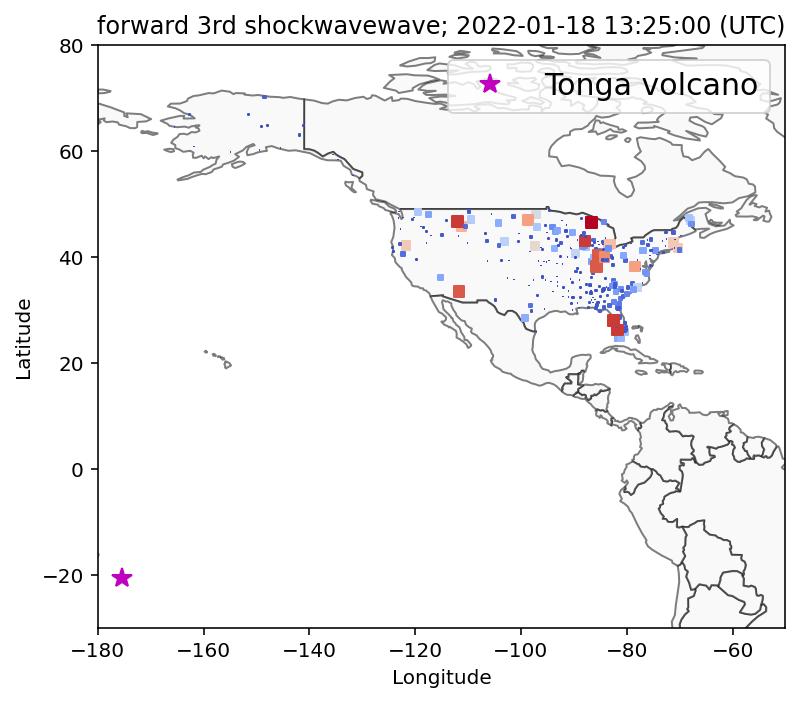

In [175]:
left_3, right_3 = 285000, 330000
plot_distributions(df_stations_3, left_3, right_3, '3rd forward')

In [79]:
df_series_back_1, df_stations_back_1, df_world = get_data(datetime.datetime(2022, 1, 16, 3, 0, 0), datetime.datetime(2022, 1, 16, 10, 0, 0))
df_stations_back_1 = calculate(df_series_back_1, df_stations_back_1)

(419, 827)


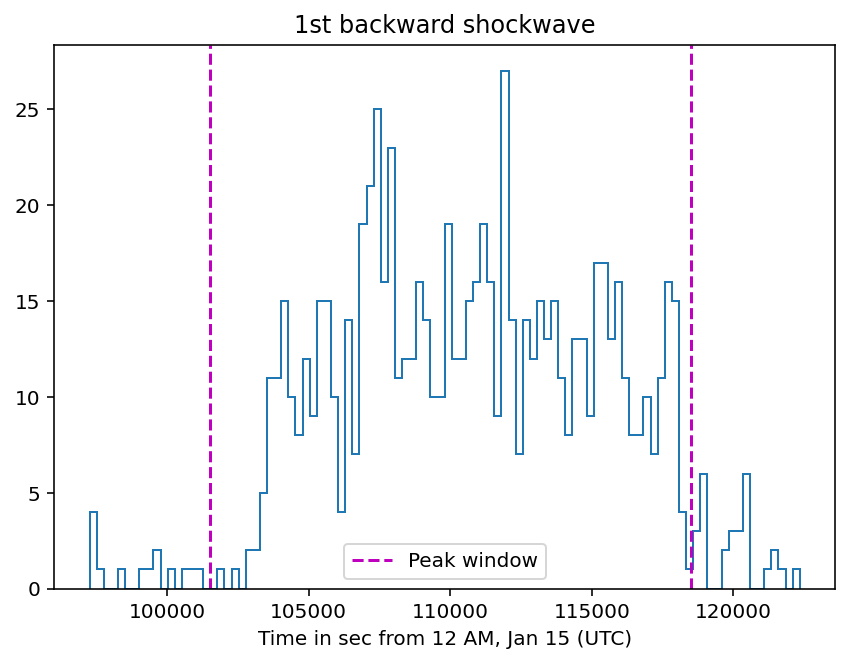

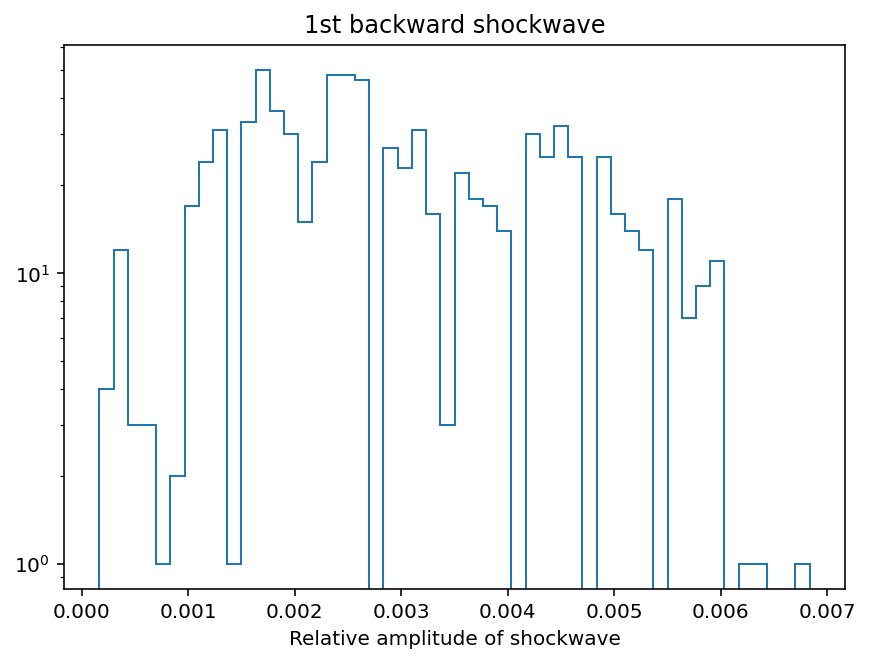

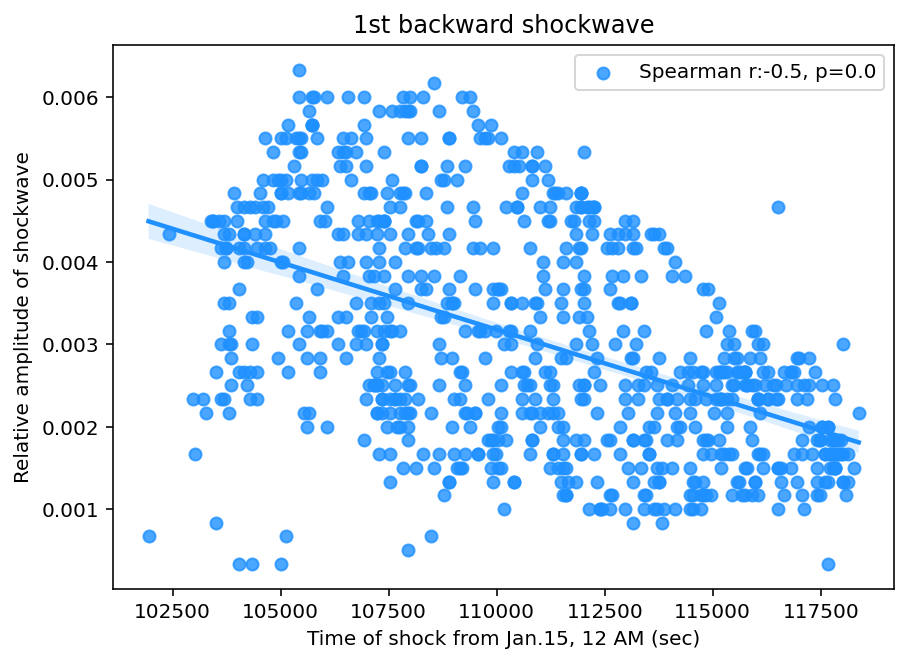

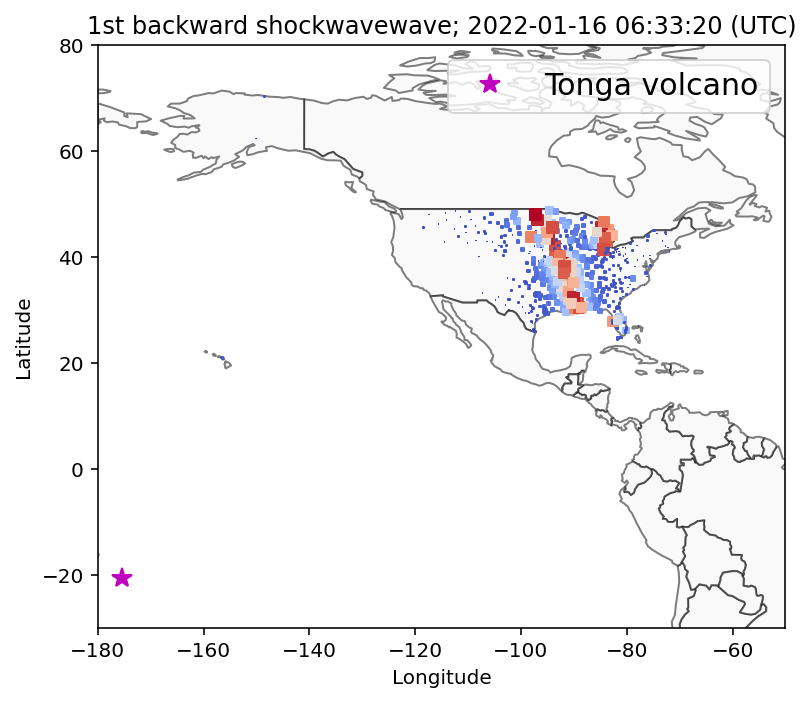

In [92]:
left_back_1, right_back_1 = 101500, 118500
plot_distributions(df_stations_back_1, left_back_1, right_back_1, '1st backward')

In [91]:
df_series_back_2, df_stations_back_2, df_world = get_data(datetime.datetime(2022, 1, 17, 13, 0, 0), datetime.datetime(2022, 1, 17, 22, 0, 0))
df_stations_back_2 = calculate(df_series_back_2, df_stations_back_2)

(539, 825)


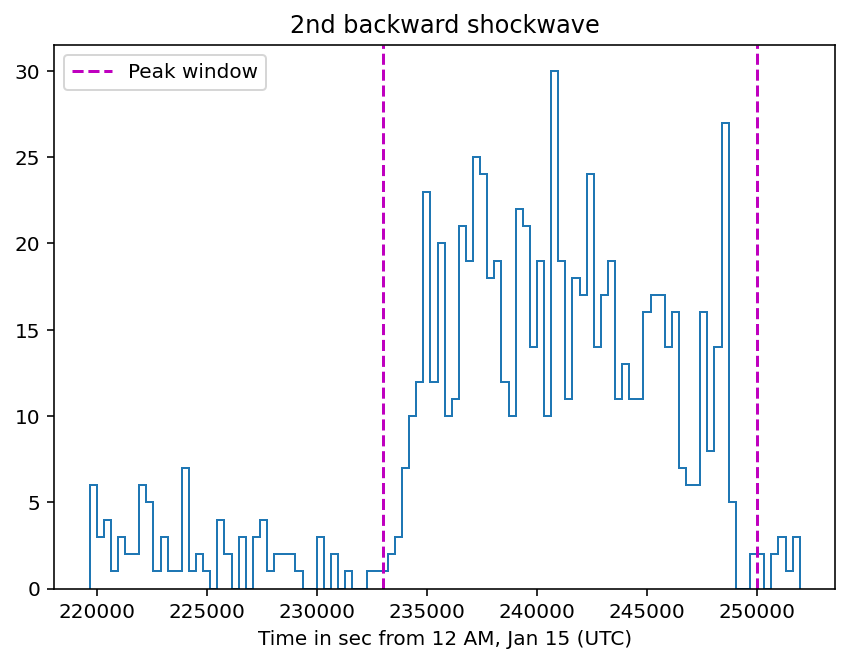

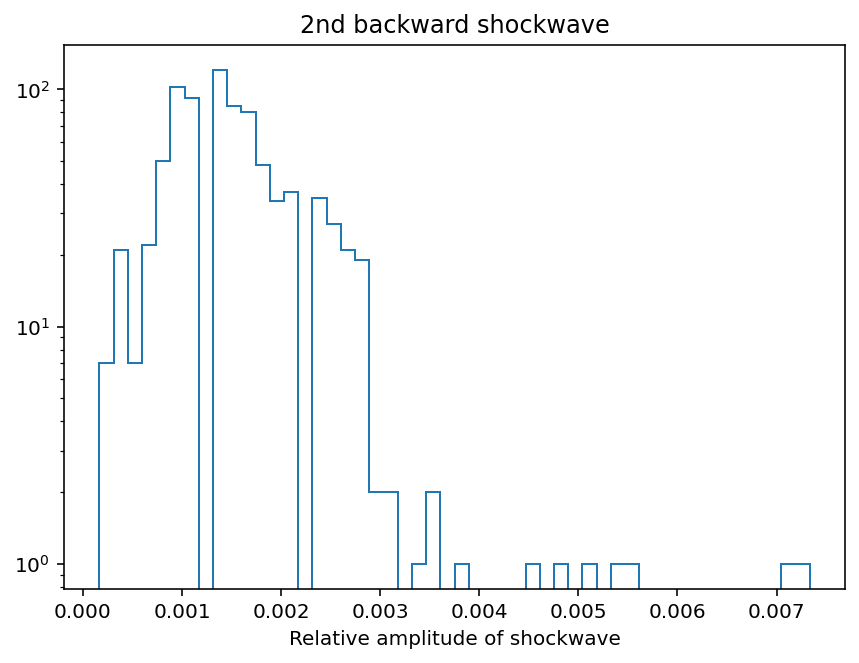

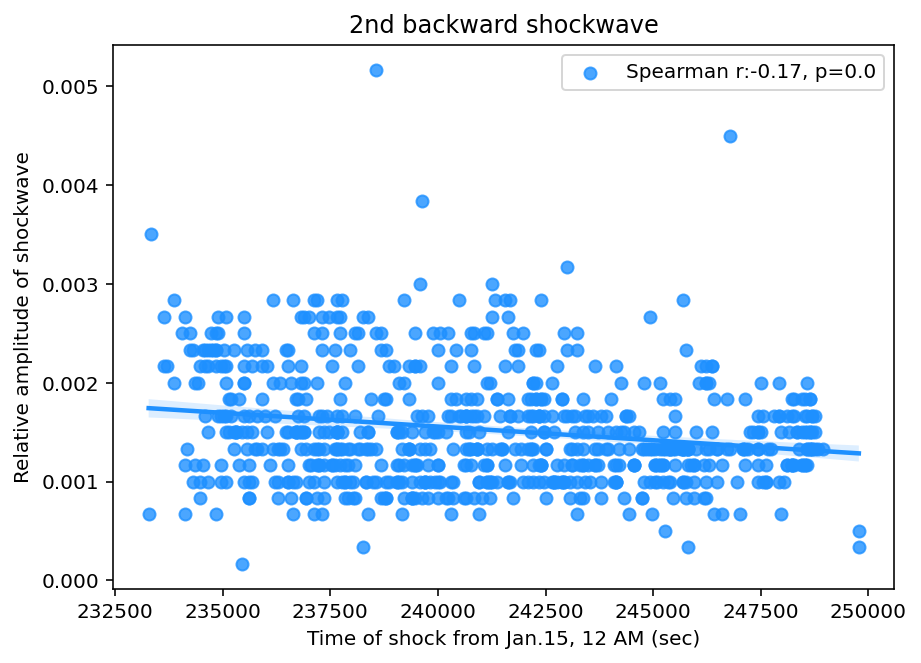

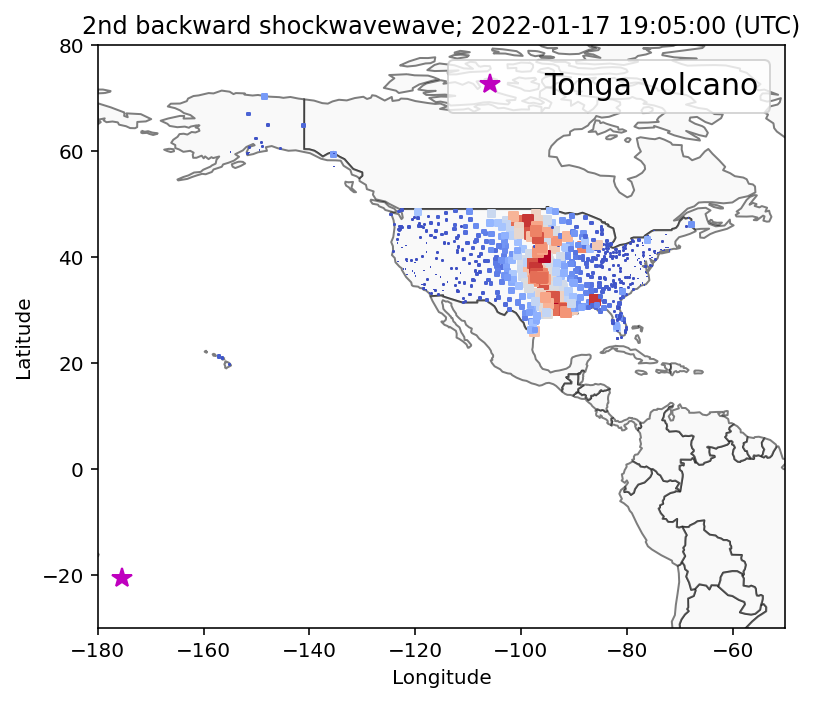

In [97]:
left_back_2, right_back_2 = 233000, 250000
plot_distributions(df_stations_back_2, left_back_2, right_back_2, '2nd backward')

In [179]:
df_series_back_3, df_stations_back_3, df_world = get_data(datetime.datetime(2022, 1, 19, 3, 0, 0), datetime.datetime(2022, 1, 19, 10, 0, 0))
df_stations_back_3 = calculate(df_series_back_3, df_stations_back_3)

(419, 816)


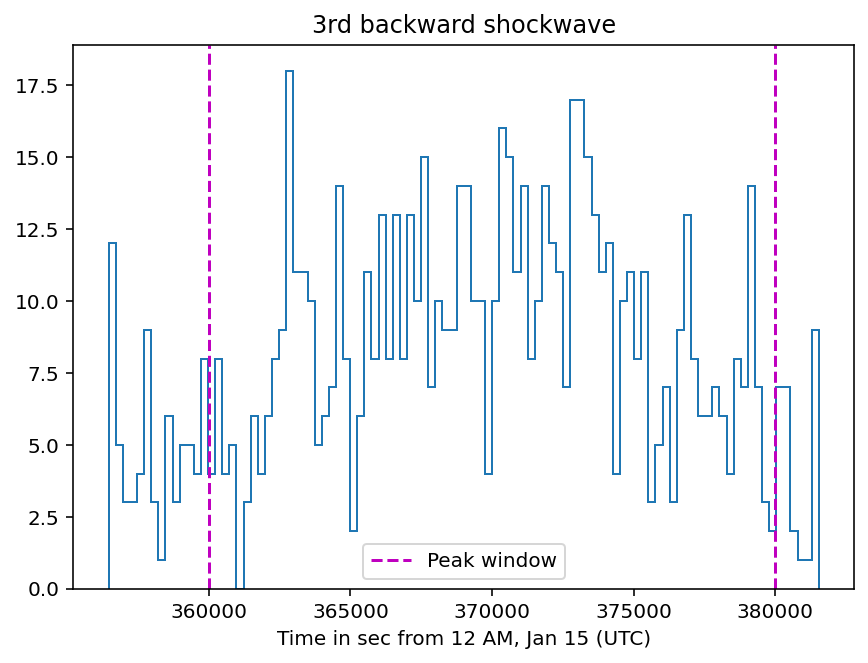

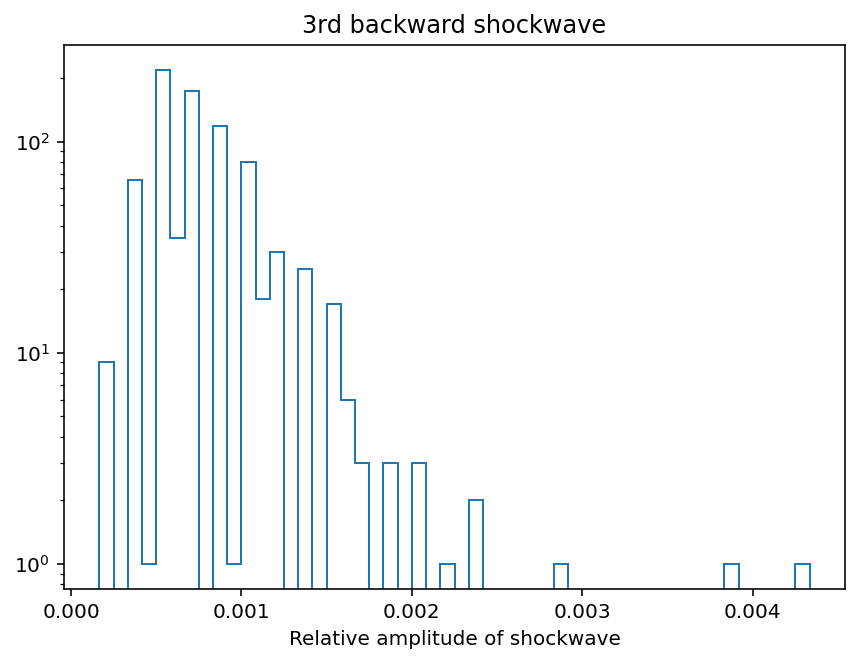

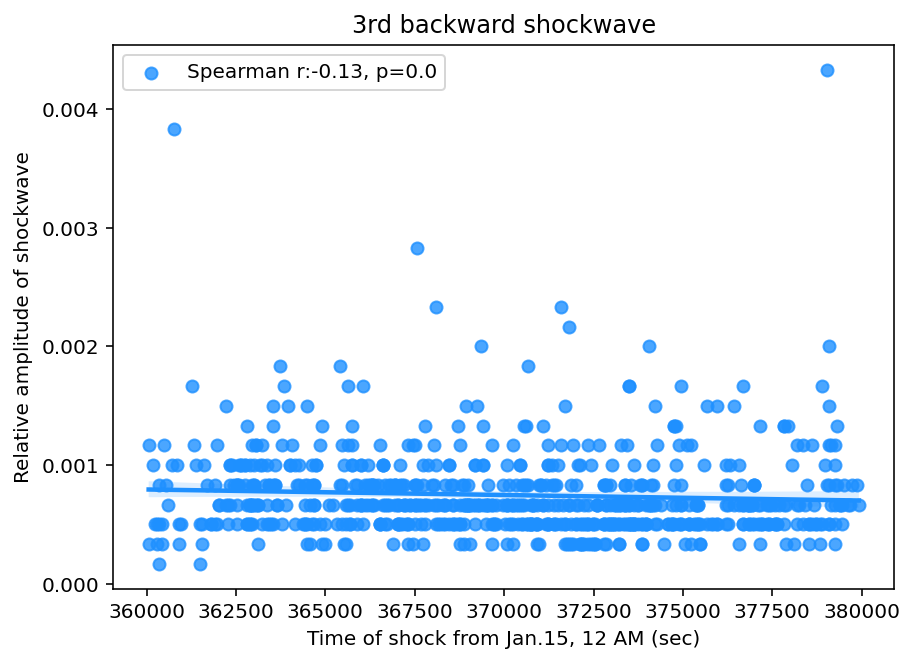

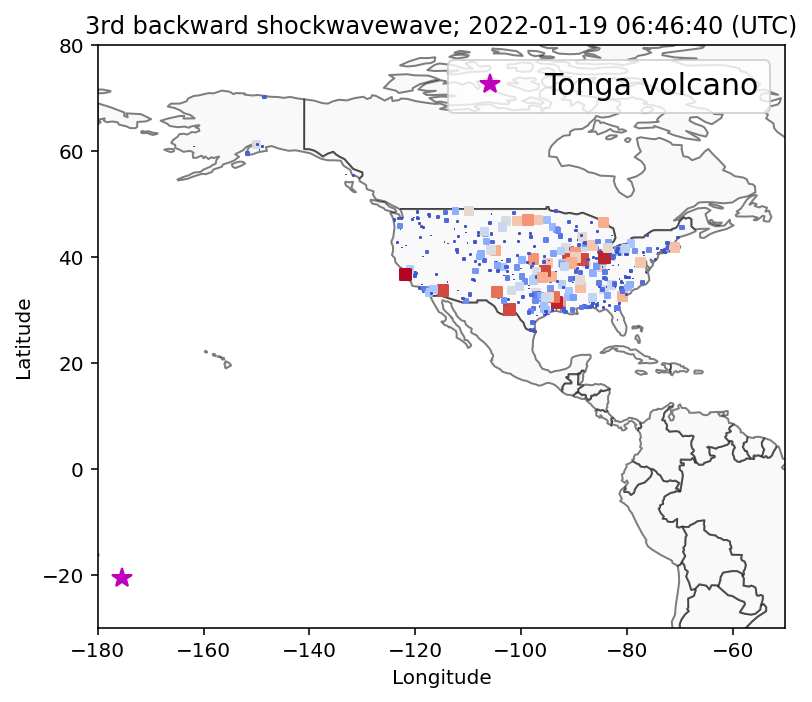

In [180]:
left_back_3, right_back_3 = 360000, 380000
plot_distributions(df_stations_back_3, left_back_3, right_back_3, '3rd backward')

# Save PNG

In [232]:
def save_frames(df_stations, left, right, shock_n):
    # save shock wave as png frames!
    for t in np.arange(left, right, 100):

        fig, ax = plt.subplots(figsize=(7,5))
        cm = matplotlib.cm.get_cmap('coolwarm')
        df_world.plot(ax=ax, color='whitesmoke', edgecolor='black', alpha=0.5)
            
        cval_raw = (1 - np.abs(df_stations['dt_shock'] - t)/50000).values
        cval_raw = (cval_raw - np.min(cval_raw)) / (np.max(cval_raw) - np.min(cval_raw))
        cval = cval_raw ** 20
        color = np.array([cm(i) for i in cval])
        ax.scatter(df_stations['lon'],df_stations['lat'], marker='s', color=color, s=30*cval, alpha=1)

        ax.plot(-175.385,-20.55, '*', color='m', markersize=10, label='Tonga volcano')
        ax.plot()
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xlim(-180, -50)
        ax.set_ylim(-30,80)
        ax.set_title(f'{shock_n}; ' + str(datetime.datetime(2022, 1, 15, 0, 0, 0) + datetime.timedelta(seconds=int(t))) + ' (UTC)')
        plt.tight_layout()
        plt.legend(prop={'size':15})
        
        plt.savefig(f'data_animation/{shock_n}_frame_{str(t).zfill(2)}.png', dpi=200)
        plt.close()

In [233]:
name = 'forward_wave_1'
f = glob.glob(f'data_animation/{name}_*.png')
for i in f:
    os.remove(i)
save_frames(df_stations_1, left_1, right_1, name)

In [183]:
name = 'forward_wave_2'
f = glob.glob(f'data_animation/{name}_*.png')
for i in f:
    os.remove(i)
save_frames(df_stations_2, left_2, right_2, name)

In [184]:
name = 'forward_wave_3'
f = glob.glob(f'data_animation/{name}_*.png')
for i in f:
    os.remove(i)
save_frames(df_stations_3, left_3, right_3, name)

In [235]:
name = 'backward_wave_1'
f = glob.glob(f'data_animation/{name}_*.png')
for i in f:
    os.remove(i)
save_frames(df_stations_back_1, left_back_1, right_back_1, name)

In [186]:
name = 'backward_wave_2'
f = glob.glob(f'data_animation/{name}_*.png')
for i in f:
    os.remove(i)
save_frames(df_stations_back_2, left_back_2, right_back_2, name)

In [187]:
name = 'backward_wave_3'
f = glob.glob(f'data_animation/{name}_*.png')
for i in f:
    os.remove(i)
save_frames(df_stations_back_3, left_back_3, right_back_3, name)

# Generate GIF

In [236]:
# save png as movie
# for i in ['forward', 'backward']:
for i in ['backward']:
    for j in range(1, 4):
        images = []
        fs = glob.glob(f'data_animation/{i}_wave_{j}*.png')
        fs.sort()
        for f in fs:
            images.append(io.imread(f))
            
        io.mimsave(f'final_cut_{i}_{j}.gif', images, fps=40)

RuntimeError: Zero images were written.